In [2]:

using Pkg
Pkg.activate("./baron_env")
#Pkg.pin("JuMP")
using JuMP
using CSV
using GraphRecipes, Plots
using LightGraphs
using LinearAlgebra
using SparseArrays
using DataFrames


  Activating environment at `~/Documents/project-codes/Plan_RoadmapsIAM/toy-problem/baron_env/Project.toml`


In [58]:
innovations = CSV.File("./data-case-roadmap/innovations.csv",header=1,delim=",") |> DataFrame
#innovations = CSV.File("./data/innovations_append.csv",header=1,delim=",") |> DataFrame
mapki = CSV.File("./data-case-roadmap/map-ki.csv",header=1,delim=",") |> DataFrame
compromise = CSV.File("./data-case-roadmap/compromise.csv",header=1,delim=",") |> DataFrame
initial = CSV.File("./data-case-roadmap/initial.csv",header=1,delim=",") |> DataFrame
ci=innovations[!,2]
rl=innovations[!,3]
initial
#innovations[2,6]=7
#compromise[!,3]=compromise[!,3]/2
#innovations[2,2]=175
#innovations[2,3]=2
#innovations[1,3]=3
#innovations[4,2]=168
#innovations[3,3]=2
innovations

,i,Cost_per_RL,RL,Sojourn1,Sojourn2,Sojourn3,Sojourn4,Sojourn5,P11
,Int64,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Int64
1,1,121.08,3,8.32,8.84,0.65,9.9,9.65,0
2,2,103.22,3,8.32,8.84,0.65,9.9,9.65,0
3,3,85.84,1,4.6,1.34,2.04,0.12,8.86,0
4,4,90.68,1,5.48,7.62,3.34,5.05,1.1,0
5,5,77.52,3,9.94,2.38,7.94,3.82,5.44,0
6,6,98.51,2,4.44,1.21,5.09,6.52,8.67,0
7,7,121.59,3,4.44,1.21,5.09,6.52,8.67,0
8,8,122.1,1,4.6,1.34,2.04,0.12,8.86,0
9,9,122.26,2,5.48,7.62,3.34,5.05,1.1,0


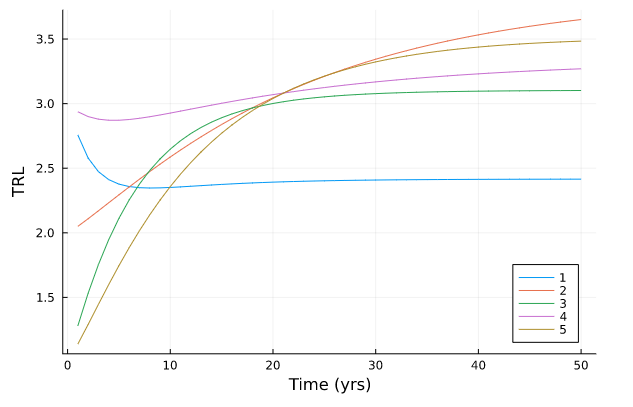

Choose Template for Innovation (1-5)MSW pyrolysis to small olefins
stdin> 4
Choose Template for Innovation (1-5)Source Segregation
stdin> 1
Choose Template for Innovation (1-5)AI robot segregation
stdin> 1
Choose Template for Innovation (1-5)LABS from PE
stdin> 2
Choose Template for Innovation (1-5)Pyrolysis of LDPE
stdin> 5
Choose Template for Innovation (1-5)Pyrolysis of HDPE
stdin> 1
Choose Template for Innovation (1-5)Pyrolysis of PP
stdin> 1
Choose Template for Innovation (1-5)Recycling back to PLA usin Clay
stdin> 4
Choose Template for Innovation (1-5)Alkaline hydrolysis of PLA
stdin> 5
Choose Template for Innovation (1-5)Alcoholysis of PLA
stdin> 4


"./data-case-roadmap/innovation-user.csv"

In [59]:
innovations[!,:Cost_per_RL].=100

display("image/png", read("./data-case-roadmap/trl_profile_template.png"))
inn_template = CSV.File("./data/innovations.csv",header=1,delim=",") |> DataFrame
for i in 1:nrow(innovations)
    println("Choose Template for Innovation (1-5)", innovations[i,:name])
    temp_inn=readline()
    innovations[1,3:ncol(inn_template)]=inn_template[parse(Int64,temp_inn),3:ncol(inn_template)]
end
innovations
#CSV.write("./data-case-roadmap/innovation-user.csv",innovations)

In [63]:
innovations[!,:Sojourn2]+=0.5*ones(nrow(innovations))
innovations[!,:Sojourn3]+=0.5*ones(nrow(innovations))

10-element Vector{Float64}:
 3.84
 1.15
 2.54
 3.84
 8.440000000000001
 5.59
 5.59
 2.54
 3.84
 3.84

In [87]:
function get_transition_mat(i)
    p_mat=reshape(collect(innovations[i,9:33]),5,5)
    return p_mat'
end


function get_rate_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return q_mat
end

function get_rate_eig_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return [q_mat,eigvecs(q_mat),eigvals(q_mat)]
end

function get_IAM_factor(t)
    return 1
end

function give_sorted(t)
    v=sortperm(t)
    return v
end


function calc_tot_co2(x,t)
    v=give_sorted(t)
    for i in 1:(size(tk)[1]-1)
        print(initial[1,3]*tk[v][1]-sum(xk[v[j]]*tk[v][j+1]*(initial[1,3]-compromise[v,3][j]) for j in 1:i))
        print("\n")
    end
    return 1
end

function get_RL_atT(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    q=get_rate_mat(i)
    #rl_t=sum([1 2 3 4 5].*(s0*exp(q*t)))
    #rl_t=sum([1 2 3 4 5].*(s0*(I+t*q+1/2*t^2*q^2)))
    temp1=Diagonal(eigvals(q))*t
    temp2=reshape(reduce(vcat,(exp(temp1))),5,5)
    d=eigvecs(q)*(temp2)*inv(eigvecs(q))
    rl_t=sum([1 2 3 4 5].*(s0*d))
    println(i," ",rl_t)
    return rl_t
end

function get_RL(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    p_mat=reshape(collect(innovations[i,9:33]),5,5)'
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    q=q_mat
    #rl_t=sum([1 2 3 4 5].*(s0*exp(q*t)))
    #rl_t=sum([1 2 3 4 5].*(s0*(I+t*q+1/2*t^2*q^2)))
    temp1=Diagonal(eigvals(q))*t
    temp2=reshape(reduce(vcat,(exp(temp1))),5,5)
    d=eigvecs(q)*(temp2)*inv(eigvecs(q))
    rl_t=sum([1 2 3 4 5].*(s0*d))
    return rl_t
end

function get_RL_DTMC(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    p_mat=reshape(collect(innovations[i,9:33]),5,5)'
    rl_t=sum([1 2 3 4 5].*(s0*p_mat^t))
    return rl_t
end
    



get_RL_DTMC (generic function with 1 method)

In [88]:
v=innovations[:,:name]
v1=reshape(v, 1,length(v))
v

10-element Vector{String31}:
 "MSW pyrolysis to small olefins"
 "Source Segregation"
 "AI robot segregation"
 "LABS from PE"
 "Pyrolysis of LDPE"
 "Pyrolysis of HDPE"
 "Pyrolysis of PP"
 "Recycling back to PLA usin Clay"
 "Alkaline hydrolysis of PLA"
 "Alcoholysis of PLA"

4 2.801202125794108
1 2.9440839786203754
1 2.9090213811291723
1 2.8885725387732406
1 2.878581646172312
1 2.87612108479461
1 2.8790681723132545
1 2.8858626253724657
1 2.895350682530217
1 2.9066774676003804
1 2.919209707553061
1 2.932479135854522
1 2.9461406313074088
1 2.959941095069442
1 2.9736962424214264
1 2.9872732625991043
1 3.0005778436866484
1 3.0135444515209038
1 3.026129038325844
1 3.038303568174246
1 3.050051902794494
1 3.0613667072646624
1 3.0722471213373326
1 3.0826970062685475
1 3.0927236247928906
1 3.1023366475112972
1 3.1115474055587176
1 3.120368329306106
1 3.128812527738976
1 3.1368934743147596
1 3.1446247734783817
1 3.1520199883127407
1 3.1590925145413324
1 3.165855489674341
1 3.172321728788107
1 3.1785036804685998
1 3.1844133979951104
1 3.1900625220127345
1 3.195462271832867
1 3.2006234431785496
1 3.2055564107078465
1 3.210271134042411
1 3.214777166329447
1 3.2190836645956056
1 3.223199401327784
1 3.2271327768511164
1 3.2308918321782705
1 3.234484262083965
1 3.23791742

10 3.1245631310860027
10 3.1328758290761143
10 3.1408192349206203
10 3.148409834722179


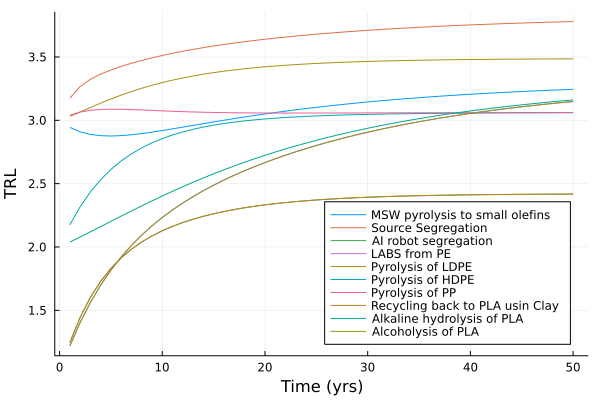

In [89]:
get_RL_atT(4,25)
pal = palette(:default)
plot_ref=plot([get_RL_atT.(i, 1:50) for i = 1:nrow(innovations)]; color = [pal[i] for i = 1:nrow(innovations)]',label=v1, legend=:bottomright,ylab="TRL", xlab="Time (yrs)")
#plot_ref=plot!(range(1, 50; length = 20), [get_RL_DTMC.(i, 1:20) for i = 1:5], linestyle = :dot, color = pal[1:5]', labels=[1,2,3,4,5]') 
#savefig("./result-case-roadmap/evolution-inn_ctmc.svg")
plot_ref

In [90]:
### iam_model=DataFrame()
#zero is 2020 SSP2-34 IMAGE 3.0.1

#iam_model[!,"Yr"]=[0;10;20;30;40;50]
#iam_model[!,"Back_RedFr_Elec"]=[1
#0.949784976
#0.809145552
#0.623734704
#0.41470694
#0.331447018]

iam_model = CSV.File("./data/iam_model.csv",header=1,delim=",") |> DataFrame
iam_model


#CSV.write("./data/iam_model.csv",iam_model)

,Yr,Back_RedFr_Elec
,Int64,Float64
1,0,1.0
2,10,0.949785
3,20,0.809146
4,30,0.623735
5,40,0.414707
6,50,0.331447


In [91]:
compromise

,k,i,GWP,Theta,Per_Recycl,Per_Comp,GHG_ElecInd,GHG_Trans,OCost
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,1,15.0711,0.621,0.0,0.0,0.499,0.122,3.4294
2,2,1,2.7837,0.3955,0.661676,0.0,0.47,0.127,1.1203
3,3,1,10.0834,0.41,0.0,1.0,0.56,0.111,0.65
4,4,1,8.9103,0.4132,0.0,0.958953,0.54,0.104,0.67
5,5,1,4.0,0.4546,0.0,0.0,0.54,0.139,0.7
6,6,1,4.1434,0.5081,0.0,0.0,0.57,0.12,0.7
7,7,1,7.1535,0.4218,0.0,0.854318,0.5,0.114,0.7
8,8,1,4.1374,0.5081,0.0,0.0,0.46,0.116,0.7
9,9,1,7.1535,0.4218,0.0,0.854318,0.52,0.132,0.7


In [92]:
function get_transition_mat(i)
    p_mat=reshape(collect(innovations[i,9:33]),5,5)
    return p_mat'
end


function get_rate_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return q_mat
end

function get_rate_eig_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return [q_mat,eigvecs(q_mat),eigvals(q_mat)]
end

function get_IAM_factor(t)
    return 1
end

function give_sorted(t)
    v=sortperm(t)
    return v
end


function calc_tot_co2(x,t)
    v=give_sorted(t)
    for i in 1:(size(tk)[1]-1)
        print(initial[1,3]*tk[v][1]-sum(xk[v[j]]*tk[v][j+1]*(initial[1,3]-compromise[v,3][j]) for j in 1:i))
        print("\n")
    end
    return 1
end

function get_RL_atT(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    q=get_rate_mat(i)
    #rl_t=sum([1 2 3 4 5].*(s0*exp(q*t)))
    #rl_t=sum([1 2 3 4 5].*(s0*(I+t*q+1/2*t^2*q^2)))
    temp1=Diagonal(eigvals(q))*t
    temp2=reshape(reduce(vcat,(exp(temp1))),5,5)
    d=eigvecs(q)*(temp2)*inv(eigvecs(q))
    rl_t=sum([1 2 3 4 5].*(s0*d))
    return rl_t
end

function get_RL(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    p_mat=reshape(collect(innovations[i,9:33]),5,5)'
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    q=q_mat
    #rl_t=sum([1 2 3 4 5].*(s0*exp(q*t)))
    #rl_t=sum([1 2 3 4 5].*(s0*(I+t*q+1/2*t^2*q^2)))
    temp1=Diagonal(eigvals(q))*t
    temp2=reshape(reduce(vcat,(exp(temp1))),5,5)
    d=eigvecs(q)*(temp2)*inv(eigvecs(q))
    rl_t=sum([1 2 3 4 5].*(s0*d))
    return rl_t
end

function get_RL_DTMC(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    p_mat=reshape(collect(innovations[i,9:33]),5,5)'
    rl_t=sum([1 2 3 4 5].*(s0*p_mat^t))
    return rl_t
end
    



get_RL_DTMC (generic function with 1 method)

## Additional functions

In [106]:
q=zeros(5,5,nrow(innovations))
a=zeros(5,5,nrow(innovations))
ainv=zeros(5,5,nrow(innovations))
d=zeros(5,1,nrow(innovations))
s0=zeros(1,5,nrow(innovations))
for i in 1:nrow(innovations)
    q[:,:,i]=round.(get_rate_eig_mat(i)[1],sigdigits=3)
    a[:,:,i]=(get_rate_eig_mat(i)[2])
    d[:,:,i]=round.(get_rate_eig_mat(i)[3],sigdigits=3)
    ainv[:,:,i]=round.(inv(get_rate_eig_mat(i)[2]),sigdigits=3)
    s0[1,rl[i],i]=1
end
rl_vals=[1 2 3 4 5]

function get_latest(i,t)
    e0=zeros(5,1,i)
    e1=zeros(5,5,i)
    e2=zeros(5,5,i)
    e3=zeros(1,5,i)
    for r in 1:5
        e0[r,1,i]=exp(d[r,1,i]*t)
    end

    for r in 1:5
        for c in 1:5
            e1[r,c,i]=e0[r,1,i]*ainv[r,c,i]
        end
    end

    for r in 1:5
        for c in 1:5
            e2[r,c,i]=sum(a[r,c1,i]*e1[c1,c,i] for c1 in 1:5)
        end
    end

    for c in 1:5
        e3[1,c,i]=sum(s0[1,r,i]*e2[r,c,i] for r in 1:5)
    end


    e4=sum(rl_vals[c]*e3[1,c,i] for c in 1:5)

    #rl_vals*([0 1 0 0 0]*a[:,:,1]*Diagonal(round.(exp.(get_new2(1,t)),sigdigits=3))*get_new3(1,t))'
    return 5-e4
end

get_latest(9,50)
#rl_vals*([0 1 0 0 0]*a[:,:,1]*Diagonal(round.(exp.(get_new2(1,t)),sigdigits=3))*get_new3(1,t))'

1.8381534745388857

In [107]:
innovations

,i,Cost_per_RL,RL,Sojourn1,Sojourn2,Sojourn3,Sojourn4,Sojourn5,P11
,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Int64
1,1,100,3,5.48,8.12,3.84,5.05,1.1,0
2,2,100,3,8.32,9.34,1.15,9.9,9.65,0
3,3,100,1,4.6,1.84,2.54,0.12,8.86,0
4,4,100,1,5.48,8.12,3.84,5.05,1.1,0
5,5,100,3,9.94,2.88,8.44,3.82,5.44,0
6,6,100,2,4.44,1.71,5.59,6.52,8.67,0
7,7,100,3,4.44,1.71,5.59,6.52,8.67,0
8,8,100,1,4.6,1.84,2.54,0.12,8.86,0
9,9,100,2,5.48,8.12,3.84,5.05,1.1,0


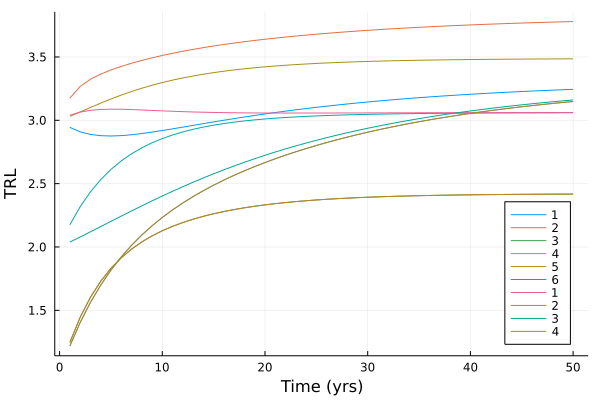

In [108]:
get_RL_atT(4,25)
pal = palette(:default)
plot([get_RL_atT.(i, 1:50) for i = 1:nrow(innovations)]; color = [pal[i] for i = 1:nrow(innovations)]',label=[1;2;3;4;5;6]', legend=:bottomright,ylab="TRL", xlab="Time (yrs)")
#plot_ref=plot!(range(1, 50; length = 20), [get_RL_DTMC.(i, 1:20) for i = 1:5], linestyle = :dot, color = pal[1:5]', labels=[1,2,3,4,5]') 
#savefig(plot_ref,"evolution-inn_ctmc.svg")

In [109]:
d1=0.982

0.982

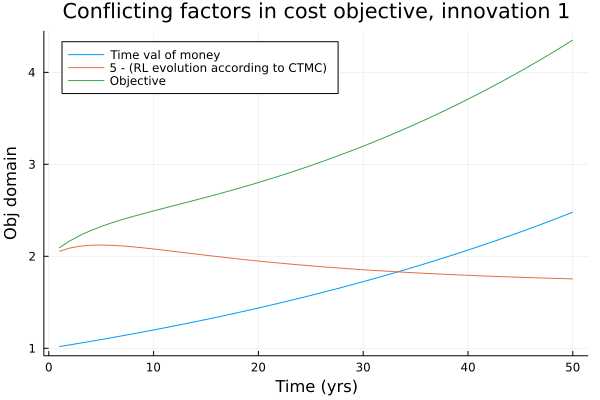

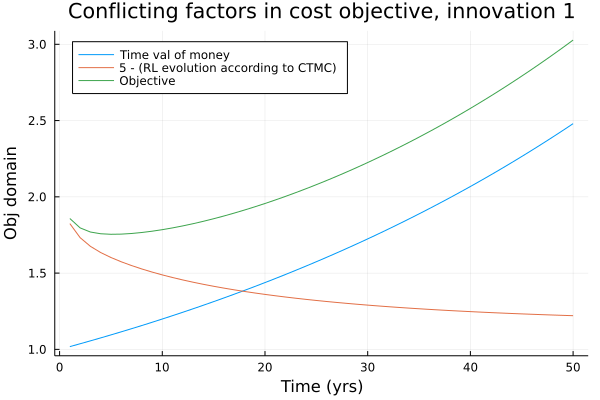

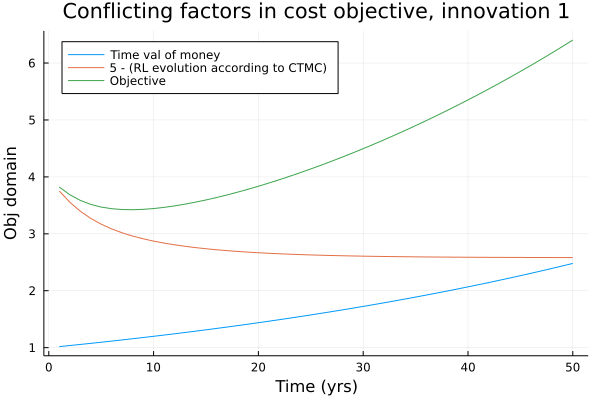

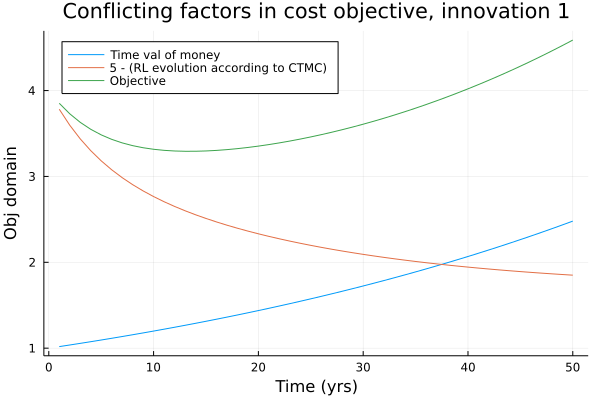

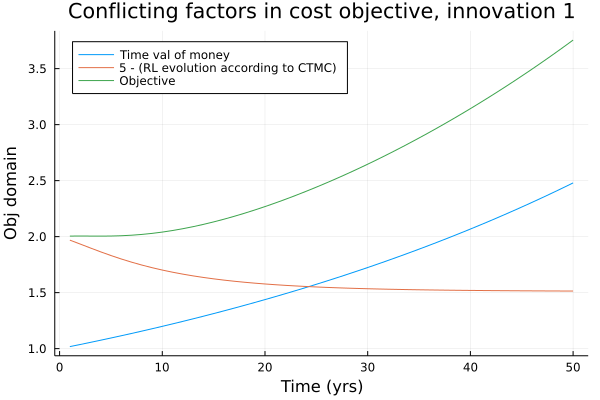

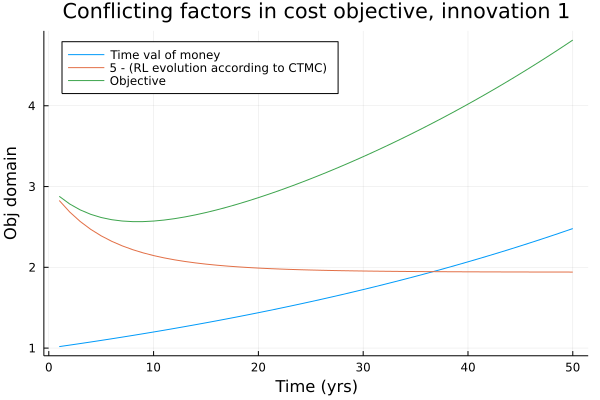

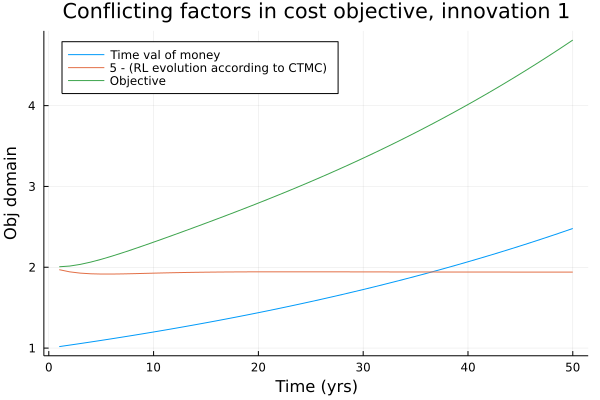

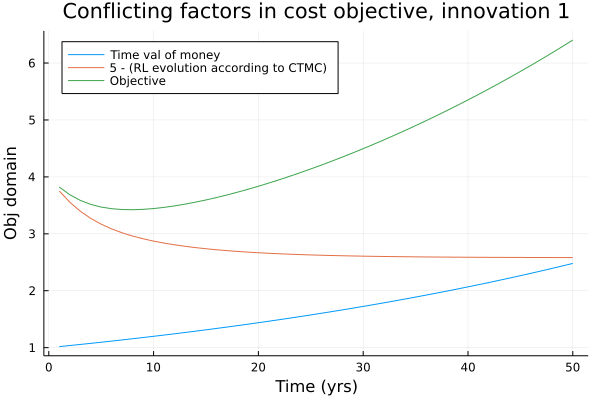

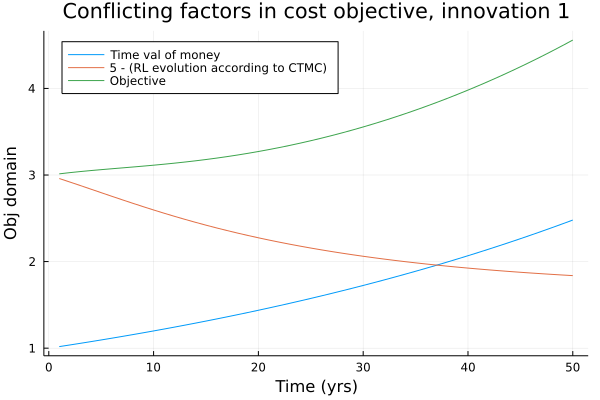

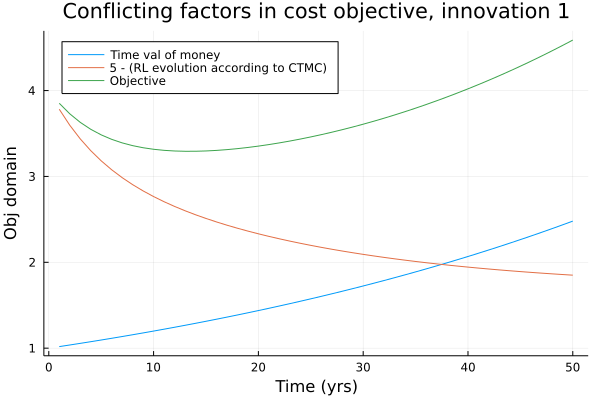

In [110]:
inn=1
for inn in 1:10
    plot(range(1, 50; length = 50),[0.982^(-1*i) for i = 1:50],labels="Time val of money")
    plot!(range(1, 50; length = 50), [get_latest.(inn,1:50)],labels="5 - (RL evolution according to CTMC)")
    plot_ref=plot!(range(1, 50; length = 50), [0.982^(-1*i)*get_latest.(inn,i) for i = 1:50], labels="Objective",legend=:topleft,
            xlab="Time (yrs)", ylab="Obj domain", title="Conflicting factors in cost objective, innovation 1")
#savefig(plot_ref,"evolution-inn_costObj.svg")
    display(plot_ref)
end

#0.986 instead of 0.968 _ NOT TRIED YET - TODO

In [111]:
intvls=40
fval=zeros(intvls+1,nrow(innovations))
tval=zeros(intvls+1,nrow(innovations))
for inn in 1:10
    tval[:,inn]=[i*(50/intvls) for i = 0:intvls]
    fval[:,inn]=[0.982^(-1*i*(50/intvls))*get_latest.(inn,i*(50/intvls)) for i =0:intvls]
end
[tval[:,1] fval]

41×11 Matrix{Float64}:
  0.0   1.99875  1.99913  3.99968  …  2.01313  3.99968  2.99777  4.00159
  1.25  2.1125   1.83764  3.78473     2.00709  3.78473  3.017    3.81923
  2.5   2.19909  1.78025  3.63336     2.02405  3.63336  3.03361  3.67753
  3.75  2.26779  1.76001  3.53254     2.05622  3.53254  3.04834  3.56817
  5.0   2.32443  1.75462  3.47006     2.09829  3.47006  3.0618   3.48446
  6.25  2.37296  1.75647  3.43618  …  2.14673  3.43618  3.07455  3.4211
  7.5   2.41615  1.76279  3.42368     2.1992   3.42368  3.0871   3.374
  8.75  2.45595  1.77243  3.42744     2.25423  3.42744  3.0999   3.33998
 10.0   2.49377  1.78484  3.44385     2.31089  3.44385  3.11333  3.31658
 11.25  2.53061  1.79967  3.47037     2.36866  3.47037  3.1277   3.30189
 12.5   2.56719  1.81669  3.50521  …  2.42725  3.50521  3.14328  3.29445
 13.75  2.60402  1.8357   3.54708     2.48655  3.54708  3.16027  3.29312
 15.0   2.64149  1.85657  3.59503     2.54654  3.59503  3.17884  3.29702
  ⋮                            

In [115]:
#CSV.write("./data-case-roadmap/cost_inn_obj.csv",  Tables.table([tval[:,1] fval]), writeheader=true)


In [113]:
g=exp(get_rate_mat(2)*50)


5×5 Matrix{Float64}:
 0.0999915  0.177499  0.0364628  0.443145  0.242902
 0.091867   0.163873  0.0357651  0.454619  0.253875
 0.0712257  0.127883  0.0339008  0.484184  0.282807
 0.0599454  0.10831   0.0328882  0.500308  0.298547
 0.0556414  0.10083   0.032489   0.506256  0.304783

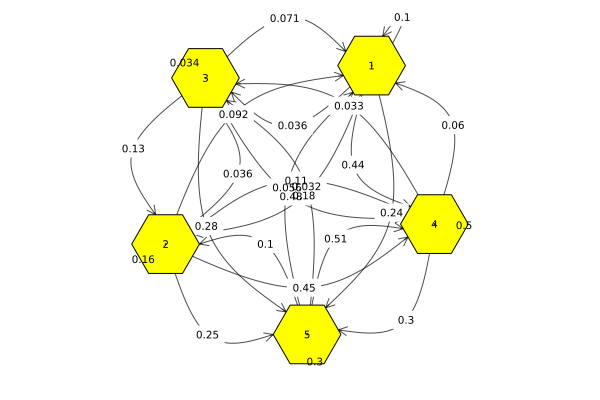

In [114]:
n = 5
edgelabel_dict = Dict()
edgelabel_mat = Array{String}(undef, n, n)
for i in 1:n
    for j in 1:n
        edgelabel_mat[i, j] = edgelabel_dict[(i, j)] = string(round(g[i,j],sigdigits=2)) 
    end
end
edgelabel_vec = edgelabel_mat[:]


graphplot(g, names=1:5, curvature_scalar=0.2,  edgelabel=edgelabel_dict, markersize = 0.5,
           linecolor = :darkgrey, markercolor = "yellow",
           linealpha = 0.7)